In [ ]:
from imports import *
from simcodes.MultiBandSim import correctedNaiveMultiband, MCSimulation
            


In [ ]:

ztf = Table.read(data_+"nph_light_curves?POS=CIRCLE 286.49621 16.098028 0.00055")

kwargs = {'format': 'ascii', 'names': ['t', 'mag', 'magerr', 'filt']}
ogle = Table.read(data_+"OGLE-GD-CEP-1442-I.dat", **kwargs)


ztf = ztf[ztf['oid']!=1585209400010477]
    
ztf['t'] = ztf['hjd']-2450000 - ztf['exptime']*0.5/(24*60*60)
ztf['filt'] = list(map(str, ztf['filtercode'].data))

df = vstack([ogle, ztf])
df = df.to_pandas()
df = df[['t','mag','magerr','filt']]
df.to_csv(data_+'testing_MC.csv')
df.groupby('filt').count()

In [4]:

Sim = MCSimulation('data/', 3.27, 'data/testing_MC.csv')


#  Lomb Scargle Fast

In [92]:
Sim.run_simulation('fast', np.arange(5,100,5),100 )

In [93]:
Sim.run_simulation('slow', np.arange(5,100,5),100 )

In [ ]:
LSFast    =np.vectorize(testing,signature="(),(),(),(),(),()->(),(),(a),(a),(b),(b,c),(c),()")(np.array([5*[i] for i in np.arange(5,200,50)]).flatten(),
                                                                                   3.27,data_+'testing_MC.csv',"fast", True,False)

lightcurve_p, lightcurve,simulated_periods = decompose(LSFast,'outputs/')

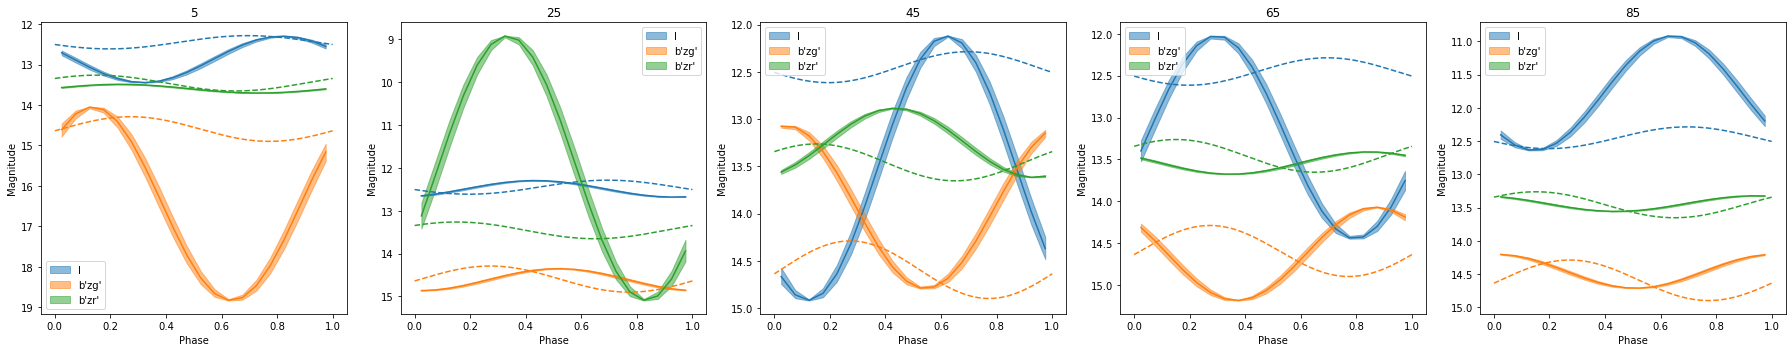

In [96]:
def plot_lightcurve(lightcurve_p,Kbf):    
    bins = pd.unique(lightcurve_p.index.get_level_values(1))[::4]
    fig,ax = plt.subplots(1,bins.size,figsize=(5*bins.size,5))
    ax = np.reshape(ax,-1)
    for TYPE in pd.unique(pd.unique(lightcurve_p.index.get_level_values(0))):
        for i,N in enumerate(bins):
            for f in pd.unique(lightcurve_p.index.get_level_values(2)):
                m = lightcurve_p.loc[(TYPE,N,f)]
                _=ax[i].plot(m.index,m['p_50'])[0].get_color()
                cut = Kbf[4]==f

                ax[i].plot(Kbf[6][cut][0],Kbf[5][cut][0],color=_,ls='dashed')
                ax[i].fill_between(m.index,m['p_16'],m['p_84'],alpha=0.5,color=_,label=f)
            ax[i].legend()
            ax[i].set_xlabel('Phase')
            ax[i].set_ylabel('Magnitude')
            ax[i].set_title(N)
            ax[i].invert_yaxis()
    fig.tight_layout()
plot_lightcurve(Sim.lightcurve_p['fast'],Sim.best_fitting)

,p_16,p_50,p_84,max,min,sem,skewness,std
N,,,,,,,,
5,0.104051,0.119003,0.153997,0.307728,0.100291,0.003784,2.491865,0.037647
10,0.143139,3.268264,3.271218,3.293364,0.100876,0.138848,-0.490295,1.381522
15,3.268781,3.270296,3.271300,3.274370,1.434220,0.057726,-2.492875,0.574365
20,3.269583,3.270231,3.270576,3.271741,0.433150,0.056656,-3.584654,0.563723
25,3.269917,3.270227,3.270803,3.272757,1.434905,0.025822,-6.857049,0.256928
30,3.270105,3.270303,3.270723,3.271823,1.434873,0.018355,-9.849251,0.182631
35,3.270095,3.270269,3.270748,3.272056,1.434845,0.018356,-9.849268,0.182636
40,3.270092,3.270272,3.270641,3.271803,3.267686,0.000049,-0.868764,0.000490
45,3.270183,3.270315,3.270571,3.271752,3.267673,0.000043,-1.468252,0.000432


No handles with labels found to put in legend.


,p_16,p_50,p_84,max,min,sem,skewness,std
N,,,,,,,,
5,0.119439,0.178214,0.765423,4.401532,0.100012,0.094971,2.493561,0.944945
10,0.764052,3.269509,3.270889,3.274620,0.102789,0.122120,-0.725749,1.215074
15,3.268615,3.270165,3.270906,3.274744,0.299676,0.070498,-2.684097,0.701449
20,3.269667,3.270254,3.270688,3.271930,0.764116,0.046420,-4.803024,0.461874
25,3.269939,3.270237,3.270536,3.271700,1.434795,0.025826,-6.857101,0.256963
30,3.270088,3.270265,3.270466,3.270884,3.268820,0.000030,-1.737662,0.000302
35,3.269994,3.270202,3.270355,3.271634,0.764136,0.025061,-9.849330,0.249350
40,3.270060,3.270237,3.270383,3.271781,1.434829,0.018354,-9.849315,0.182620
45,3.270117,3.270219,3.270343,3.271042,3.269174,0.000024,-0.586648,0.000243


No handles with labels found to put in legend.


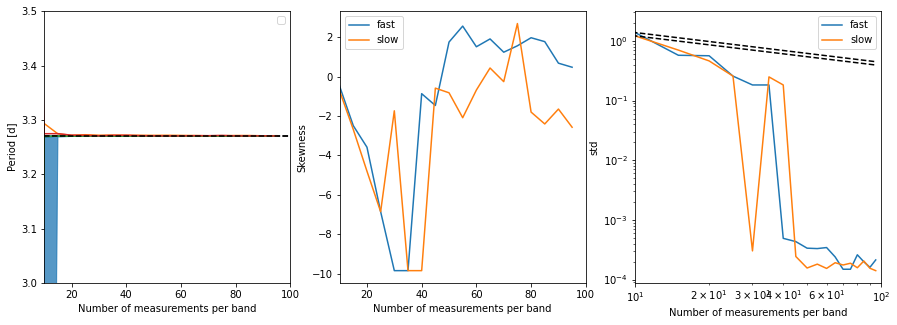

In [95]:
def periods(simulated_periods, P0,label,FIG=None):
    import scipy.stats as sc
    mean = simulated_periods.groupby(simulated_periods['N'],).median()
    p16 =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.percentile(x.dropna(),16))
    p84 =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.percentile(x.dropna(),84))
    p100 =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.max(x.dropna(),))
    skewness  =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:sc.skew(x.dropna(),))
    std = simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.std(x.dropna(),))
    moments = {'P': [
                                                                                lambda x: np.percentile(x.dropna(),16),
                                                                                lambda x: np.percentile(x.dropna(),50),
                                                                                lambda x: np.percentile(x.dropna(),84),
                                                                                lambda x: np.max(x.dropna()),
                                                                                lambda x: np.min(x.dropna()),
                                                                                lambda x: sc.sem(x.dropna()),
                                                                                lambda x: sc.skew(x.dropna()),
                                                                                lambda x: np.std(x.dropna())]}
    moments = simulated_periods.groupby(simulated_periods['N'],).agg(moments)
    moments.columns = ['p_16', 'p_50', 'p_84','max','min','sem','skewness','std']
    display(moments)
    if FIG is None:
        fig,ax = plt.subplots(1,3,figsize=(15,5))
    else:
        fig,ax=FIG
    ax[0].plot(moments.index,moments.p_50)
    ax[0].plot(moments.index,moments['max'])
    ax[0].set_ylim(3,3.5)
    ax[0].fill_between(moments.index,moments.p_16,moments.p_84,alpha=0.5,color='C0')
    ax[0].axhline(P0,color='k',ls='dashed')
    
    ax[0].set_ylabel('Period [d]')
    ax[1].plot(moments.index,moments.skewness,label=label)
    
    ax[2].plot(moments.index,moments['std'],label=label)
    x = np.linspace(moments.index.min(),moments.index.max())
    xm = moments[moments['std']==moments['std'].max()].index.values[0]
    ax[2].set_xscale('log')
    ax[2].plot(x,moments['std'].max()*np.sqrt(xm/x),'k',ls='dashed')
    ax[2].set_yscale('log')
    ax[2].set_ylabel('std')
    ax[1].set_ylabel('Skewness')
    for axx in ax:
        axx.set_xlim(10,100)
        axx.legend()
        axx.set_xlabel('Number of measurements per band')
    return fig,ax
FIG=periods(Sim.simulated_periods['fast'],3.27,'fast')
FIG=periods(Sim.simulated_periods['slow'],3.27,'slow',FIG)

# Naive Multiband

In [ ]:
Naive\
    =np.vectorize(testing,signature="(),(),(),(),(),()->(),(),(a),(b,a),(b),(b,c),(b,c),()")(np.array([5*[i] for i in np.arange(5,200,5)]).flatten(),
                                                                                   3.27,data_+'testing_MC.csv',"naive", True,False)


#simulated_periods= pd.DataFrame({"N":MCN,"P":MCPeriods})
#lightcurve = pd.DataFrame()
#for _filter in pd.unique(MCFilter.flatten()):
#    
#    cut = MCFilter==_filter
#    phase =  MCPhase
#    for i,N in enumerate(pd.unique(MCN)):
#        
#        lightcurve=lightcurve.append(pd.DataFrame({"N":MCPhase.shape[-1]*[N], 
#                                                   "Filter":MCPhase.shape[-1]*[_filter], 
#                                                   "phase":MCPhase[cut][i], 
#                                                   "mag":MCMag[cut][i],"kind":MCType[i]}),ignore_index=True)
#lightcurve['phase bin'] = pd.cut(lightcurve.phase,20).apply(lambda x: x.mid)
#
#lightcurve_p = lightcurve.groupby(["kind",'N','Filter','phase bin',]).agg({'mag': [
#                                                                        lambda x: np.percentile(x,16),
#                                                                        lambda x: np.percentile(x,50),
#                                                                        lambda x: np.percentile(x,84)]})
#lightcurve_p.columns = ['p_16', 'p_50', 'p_84']
#
#lightcurve.to_csv('lightcurve_naive.csv')
#lightcurve_p.to_csv('lightcurve_p_naive.csv')

Finding optimal frequency:
 - Estimated peak width = 0.0583
 - Using 5 steps per peak; omega_step = 0.0117
 - User-specified period range:  0.1 to 10
 - Computing periods at 5337 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0188
 - Using 5 steps per peak; omega_step = 0.00376
 - User-specified period range:  0.1 to 10
 - Computing periods at 16543 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0153
 - Using 5 steps per peak; omega_step = 0.00307
 - User-specified period range:  0.1 to 10
 - Computing periods at 20295 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0181
 - Using 5 steps per peak; omega_step = 0.00361
 - User-specified period range:  0.1 to 10
 - Computing periods at 17229 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0176
 - Using 5 steps per peak; omega_step = 0.00353
 - User-specified period range:  0.1 to 10
 - Computing periods at 17628 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0133
 - Using 5 steps per peak; omega_step = 0.00267
 - User-specified period range:  0.1 to 10
 - Computing periods at 23308 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0184
 - Using 5 steps per peak; omega_step = 0.00367
 - User-specified period range:  0.1 to 10
 - Computing periods at 16931 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0157
 - Using 5 steps per peak; omega_step = 0.00314
 - User-specified period range:  0.1 to 10
 - Computing periods at 19804 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0141
 - Using 5 steps per peak; omega_step = 0.00282
 - User-specified period range:  0.1 to 10
 - Computing periods at 22070 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0158
 - Using 5 steps per peak; omega_step = 0.00316
 - User-specified period range:  0.1 to 10
 - Computing periods at 19705 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0117
 - Using 5 steps per peak; omega_step = 0.00234
 - User-specified period range:  0.1 to 10
 - Computing periods at 26567 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0241
 - Using 5 steps per peak; omega_step = 0.00483
 - User-specified period range:  0.1 to 10
 - Computing periods at 12885 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.197
 - Using 5 steps per peak; omega_step = 0.0394
 - User-specified period range:  0.1 to 10
 - Computing periods at 1581 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0169
 - Using 5 steps per peak; omega_step = 0.00339
 - User-specified period range:  0.1 to 10
 - Computing periods at 18367 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0173
 - Using 5 steps per peak; omega_step = 0.00346
 - User-specified period range:  0.1 to 10
 - Computing periods at 17972 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0159
 - Using 5 steps per peak; omega_step = 0.00318
 - User-specified period range:  0.1 to 10
 - Computing periods at 19546 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29532 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0133
 - Using 5 steps per peak; omega_step = 0.00266
 - User-specified period range:  0.1 to 10
 - Computing periods at 23358 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0692
 - Using 5 steps per peak; omega_step = 0.0138
 - User-specified period range:  0.1 to 10
 - Computing periods at 4495 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00274
 - User-specified period range:  0.1 to 10
 - Computing periods at 22716 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0142
 - Using 5 steps per peak; omega_step = 0.00283
 - User-specified period range:  0.1 to 10
 - Computing periods at 21975 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00225
 - User-specified period range:  0.1 to 10
 - Computing periods at 27707 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00228
 - User-specified period range:  0.1 to 10
 - Computing periods at 27256 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00393
 - Using 5 steps per peak; omega_step = 0.000787
 - User-specified period range:  0.1 to 10
 - Computing periods at 79085 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0126
 - Using 5 steps per peak; omega_step = 0.00252
 - User-specified period range:  0.1 to 10
 - Computing periods at 24689 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.026
 - Using 5 steps per peak; omega_step = 0.0052
 - User-specified period range:  0.1 to 10
 - Computing periods at 11961 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79284 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0164
 - Using 5 steps per peak; omega_step = 0.00327
 - User-specified period range:  0.1 to 10
 - Computing periods at 19005 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0147
 - Using 5 steps per peak; omega_step = 0.00293
 - User-specified period range:  0.1 to 10
 - Computing periods at 21230 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00409
 - Using 5 steps per peak; omega_step = 0.000817
 - User-specified period range:  0.1 to 10
 - Computing periods at 76118 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0118
 - Using 5 steps per peak; omega_step = 0.00236
 - User-specified period range:  0.1 to 10
 - Computing periods at 26374 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28395 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00398
 - Using 5 steps per peak; omega_step = 0.000796
 - User-specified period range:  0.1 to 10
 - Computing periods at 78146 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0108
 - Using 5 steps per peak; omega_step = 0.00215
 - User-specified period range:  0.1 to 10
 - Computing periods at 28889 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0125
 - Using 5 steps per peak; omega_step = 0.00251
 - User-specified period range:  0.1 to 10
 - Computing periods at 24786 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00413
 - Using 5 steps per peak; omega_step = 0.000825
 - User-specified period range:  0.1 to 10
 - Computing periods at 75377 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29236 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0153
 - Using 5 steps per peak; omega_step = 0.00307
 - User-specified period range:  0.1 to 10
 - Computing periods at 20292 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.004
 - Using 5 steps per peak; omega_step = 0.0008
 - User-specified period range:  0.1 to 10
 - Computing periods at 77753 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0127
 - Using 5 steps per peak; omega_step = 0.00254
 - User-specified period range:  0.1 to 10
 - Computing periods at 24490 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00228
 - User-specified period range:  0.1 to 10
 - Computing periods at 27256 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0177
 - Using 5 steps per peak; omega_step = 0.00353
 - User-specified period range:  0.1 to 10
 - Computing periods at 17620 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0151
 - Using 5 steps per peak; omega_step = 0.00301
 - User-specified period range:  0.1 to 10
 - Computing periods at 20634 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00273
 - User-specified period range:  0.1 to 10
 - Computing periods at 22760 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00405
 - Using 5 steps per peak; omega_step = 0.00081
 - User-specified period range:  0.1 to 10
 - Computing periods at 76811 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27852 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0366
 - Using 5 steps per peak; omega_step = 0.00732
 - User-specified period range:  0.1 to 10
 - Computing periods at 8497 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27800 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00221
 - User-specified period range:  0.1 to 10
 - Computing periods at 28198 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0154
 - Using 5 steps per peak; omega_step = 0.00307
 - User-specified period range:  0.1 to 10
 - Computing periods at 20239 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 28000 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0133
 - Using 5 steps per peak; omega_step = 0.00267
 - User-specified period range:  0.1 to 10
 - Computing periods at 23304 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0165
 - Using 5 steps per peak; omega_step = 0.00329
 - User-specified period range:  0.1 to 10
 - Computing periods at 18903 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00225
 - User-specified period range:  0.1 to 10
 - Computing periods at 27604 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0123
 - Using 5 steps per peak; omega_step = 0.00246
 - User-specified period range:  0.1 to 10
 - Computing periods at 25328 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00413
 - Using 5 steps per peak; omega_step = 0.000826
 - User-specified period range:  0.1 to 10
 - Computing periods at 75279 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29037 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0129
 - Using 5 steps per peak; omega_step = 0.00258
 - User-specified period range:  0.1 to 10
 - Computing periods at 24093 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00396
 - Using 5 steps per peak; omega_step = 0.000792
 - User-specified period range:  0.1 to 10
 - Computing periods at 78590 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00221
 - User-specified period range:  0.1 to 10
 - Computing periods at 28198 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27362 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0125
 - Using 5 steps per peak; omega_step = 0.0025
 - User-specified period range:  0.1 to 10
 - Computing periods at 24886 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0129
 - Using 5 steps per peak; omega_step = 0.00258
 - User-specified period range:  0.1 to 10
 - Computing periods at 24096 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29187 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0134
 - Using 5 steps per peak; omega_step = 0.00269
 - User-specified period range:  0.1 to 10
 - Computing periods at 23161 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0149
 - Using 5 steps per peak; omega_step = 0.00299
 - User-specified period range:  0.1 to 10
 - Computing periods at 20833 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00208
 - User-specified period range:  0.1 to 10
 - Computing periods at 29929 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0134
 - Using 5 steps per peak; omega_step = 0.00268
 - User-specified period range:  0.1 to 10
 - Computing periods at 23254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00273
 - User-specified period range:  0.1 to 10
 - Computing periods at 22763 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27360 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0128
 - Using 5 steps per peak; omega_step = 0.00256
 - User-specified period range:  0.1 to 10
 - Computing periods at 24293 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79284 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0108
 - Using 5 steps per peak; omega_step = 0.00216
 - User-specified period range:  0.1 to 10
 - Computing periods at 28840 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0141
 - Using 5 steps per peak; omega_step = 0.00281
 - User-specified period range:  0.1 to 10
 - Computing periods at 22123 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00398
 - Using 5 steps per peak; omega_step = 0.000796
 - User-specified period range:  0.1 to 10
 - Computing periods at 78146 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29187 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00274
 - User-specified period range:  0.1 to 10
 - Computing periods at 22710 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27753 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00226
 - User-specified period range:  0.1 to 10
 - Computing periods at 27505 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00396
 - Using 5 steps per peak; omega_step = 0.000792
 - User-specified period range:  0.1 to 10
 - Computing periods at 78590 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00212
 - User-specified period range:  0.1 to 10
 - Computing periods at 29384 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27408 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00399
 - Using 5 steps per peak; omega_step = 0.000798
 - User-specified period range:  0.1 to 10
 - Computing periods at 77998 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29680 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.014
 - Using 5 steps per peak; omega_step = 0.00279
 - User-specified period range:  0.1 to 10
 - Computing periods at 22269 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79284 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0126
 - Using 5 steps per peak; omega_step = 0.00252
 - User-specified period range:  0.1 to 10
 - Computing periods at 24692 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27408 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00393
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79234 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29038 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00229
 - User-specified period range:  0.1 to 10
 - Computing periods at 27208 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00394
 - Using 5 steps per peak; omega_step = 0.000787
 - User-specified period range:  0.1 to 10
 - Computing periods at 79035 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00228
 - User-specified period range:  0.1 to 10
 - Computing periods at 27261 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0115
 - Using 5 steps per peak; omega_step = 0.00229
 - User-specified period range:  0.1 to 10
 - Computing periods at 27109 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29482 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28395 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27800 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0119
 - Using 5 steps per peak; omega_step = 0.00237
 - User-specified period range:  0.1 to 10
 - Computing periods at 26220 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0116
 - Using 5 steps per peak; omega_step = 0.00232
 - User-specified period range:  0.1 to 10
 - Computing periods at 26861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0118
 - Using 5 steps per peak; omega_step = 0.00235
 - User-specified period range:  0.1 to 10
 - Computing periods at 26416 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0115
 - Using 5 steps per peak; omega_step = 0.00229
 - User-specified period range:  0.1 to 10
 - Computing periods at 27160 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0117
 - Using 5 steps per peak; omega_step = 0.00234
 - User-specified period range:  0.1 to 10
 - Computing periods at 26615 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29087 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27357 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29186 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27404 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00217
 - User-specified period range:  0.1 to 10
 - Computing periods at 28643 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00221
 - User-specified period range:  0.1 to 10
 - Computing periods at 28199 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00225
 - User-specified period range:  0.1 to 10
 - Computing periods at 27703 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0108
 - Using 5 steps per peak; omega_step = 0.00215
 - User-specified period range:  0.1 to 10
 - Computing periods at 28890 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28396 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29630 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0128
 - Using 5 steps per peak; omega_step = 0.00255
 - User-specified period range:  0.1 to 10
 - Computing periods at 24390 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0118
 - Using 5 steps per peak; omega_step = 0.00237
 - User-specified period range:  0.1 to 10
 - Computing periods at 26268 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 27999 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79284 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29433 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0125
 - Using 5 steps per peak; omega_step = 0.0025
 - User-specified period range:  0.1 to 10
 - Computing periods at 24884 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30028 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00225
 - User-specified period range:  0.1 to 10
 - Computing periods at 27704 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 27999 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00405
 - Using 5 steps per peak; omega_step = 0.00081
 - User-specified period range:  0.1 to 10
 - Computing periods at 76811 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29532 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0125
 - Using 5 steps per peak; omega_step = 0.00251
 - User-specified period range:  0.1 to 10
 - Computing periods at 24786 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00273
 - User-specified period range:  0.1 to 10
 - Computing periods at 22756 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28347 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29187 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27900 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29432 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27852 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00405
 - Using 5 steps per peak; omega_step = 0.00081
 - User-specified period range:  0.1 to 10
 - Computing periods at 76811 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00228
 - User-specified period range:  0.1 to 10
 - Computing periods at 27261 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27453 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0108
 - Using 5 steps per peak; omega_step = 0.00216
 - User-specified period range:  0.1 to 10
 - Computing periods at 28840 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0116
 - Using 5 steps per peak; omega_step = 0.00232
 - User-specified period range:  0.1 to 10
 - Computing periods at 26811 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00209
 - User-specified period range:  0.1 to 10
 - Computing periods at 29830 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27850 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00208
 - User-specified period range:  0.1 to 10
 - Computing periods at 29882 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0125
 - Using 5 steps per peak; omega_step = 0.00251
 - User-specified period range:  0.1 to 10
 - Computing periods at 24793 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27802 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79284 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0108
 - Using 5 steps per peak; omega_step = 0.00216
 - User-specified period range:  0.1 to 10
 - Computing periods at 28743 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00221
 - User-specified period range:  0.1 to 10
 - Computing periods at 28199 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00275
 - User-specified period range:  0.1 to 10
 - Computing periods at 22658 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0108
 - Using 5 steps per peak; omega_step = 0.00215
 - User-specified period range:  0.1 to 10
 - Computing periods at 28891 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 27999 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00208
 - User-specified period range:  0.1 to 10
 - Computing periods at 29978 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27850 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30027 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27800 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27362 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 28002 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00215
 - User-specified period range:  0.1 to 10
 - Computing periods at 28939 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27362 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0115
 - Using 5 steps per peak; omega_step = 0.00229
 - User-specified period range:  0.1 to 10
 - Computing periods at 27157 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


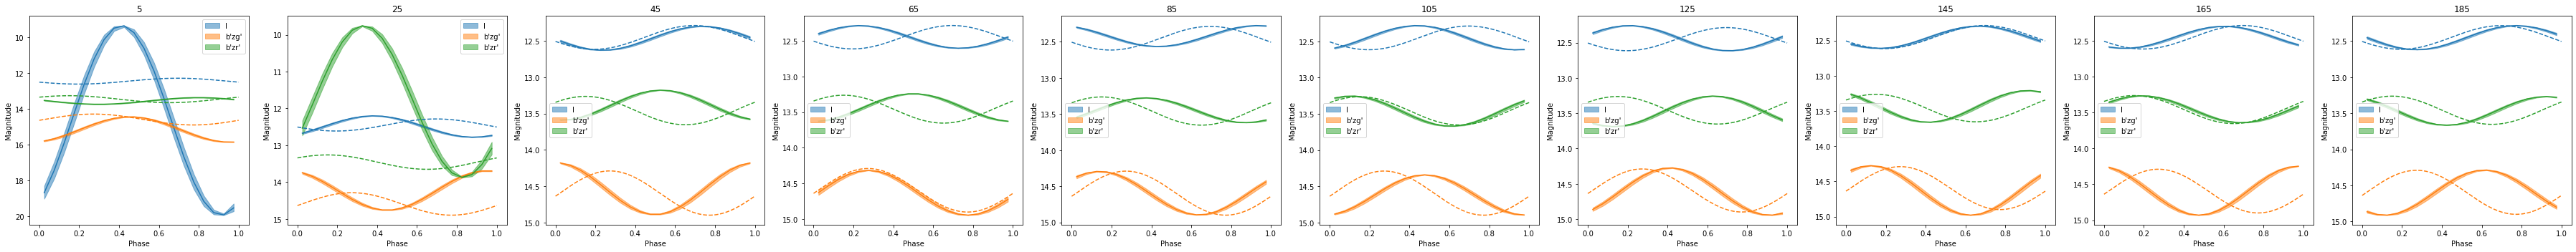

In [43]:
bins = pd.unique(lightcurve_p.index.get_level_values(1))[::4]
fig,ax = plt.subplots(1,bins.size,figsize=(5*bins.size,5))
ax = np.reshape(ax,-1)
for TYPE in pd.unique(pd.unique(lightcurve_p.index.get_level_values(0))):
    for i,N in enumerate(bins):
        for f in pd.unique(lightcurve_p.index.get_level_values(2)):
            m = lightcurve_p.loc[(TYPE,N,f)]
            _=ax[i].plot(m.index,m['p_50'])[0].get_color()
            cut = Kbf[4]==f
            
            ax[i].plot(Kbf[6][cut][0],Kbf[5][cut][0],color=_,ls='dashed')
            ax[i].fill_between(m.index,m['p_16'],m['p_84'],alpha=0.5,color=_,label=f)
        ax[i].legend()
        ax[i].set_xlabel('Phase')
        ax[i].set_ylabel('Magnitude')
        ax[i].set_title(N)
        ax[i].invert_yaxis()
fig.tight_layout()

Text(0, 0.5, 'Period [d]')

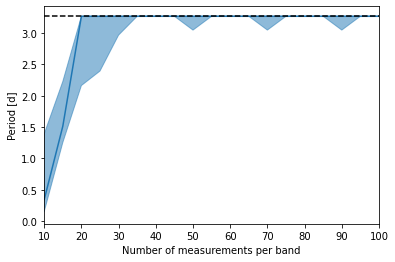

In [45]:
mean = simulated_periods.groupby(simulated_periods['N'],).median()
p16 =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.percentile(x.dropna(),16))
p84 =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.percentile(x.dropna(),84))
plt.plot(mean.index,mean.P)
plt.fill_between(mean.index,p16.P,p84.P,alpha=0.5,color='C0')
plt.xlim(10,100)
plt.axhline(P0,color='k',ls='dashed')
plt.xlabel('Number of measurements per band')
plt.ylabel('Period [d]')